# Mirror Images for eScriptorium (Non‑Expert)

This notebook mirrors page images (usually **horizontal mirror**) so you can upload the corrected images to **eScriptorium**.
**No code edits needed** — just upload your images and run all cells.

**What you can upload**
- A **ZIP** of images (recommended). Folders inside the ZIP are supported.
- Or **multiple image files** directly (JPG, PNG, TIFF, WEBP).

**What you get**
- A **ZIP** with mirrored images.
- A **CSV** mapping original filenames → mirrored filenames.
- Optional previews of a few samples.

## 1) Setup (no changes needed)

In [ ]:
try:
    import pip
    pip.main(['install', 'pillow-heif'])
except Exception:
    pass

from PIL import Image, ImageOps, UnidentifiedImageError
import io, os, zipfile, csv, shutil, itertools
from pathlib import Path

WORK = Path('/content/mirror_work'); WORK.mkdir(parents=True, exist_ok=True)
IN_DIR = WORK / 'in'; IN_DIR.mkdir(exist_ok=True)
OUT_DIR = WORK / 'out'; OUT_DIR.mkdir(exist_ok=True)

print("Workspace ready:", WORK)

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting pillow-heif

Downloading pillow_heif-1.1.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.6 kB)

Requirement already satisfied: pillow>=11.1.0 in /usr/local/lib/python3.12/dist-packages (from pillow-heif) (11.3.0)

Downloading pillow_heif-1.1.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (5.5 MB)

Output()

Installing collected packages: pillow-heif

Successfully installed pillow-heif-1.1.1

Workspace ready: /content/mirror_work


## 2) Upload images (ZIP or multiple files)

In [ ]:
from google.colab import files

print("Upload a ZIP (recommended) or select multiple image files:")
uploads = files.upload()
assert uploads, "No files uploaded."

# Save uploads and extract ZIPs (if any)
for name, data in uploads.items():
    p = WORK / name
    with open(p, 'wb') as f:
        f.write(data)
    if name.lower().endswith('.zip'):
        with zipfile.ZipFile(p, 'r') as zf:
            zf.extractall(IN_DIR)
    else:
        # single file – copy into IN_DIR
        dest = IN_DIR / name
        if not dest.exists():
            with open(dest, 'wb') as f:
                f.write(data)

print("Input folder:", IN_DIR)
print("Sample files:", list(itertools.islice((str(p) for p in IN_DIR.rglob('*') if p.is_file()), 10)))

Upload a ZIP (recommended) or select multiple image files:


Saving Ave976_072v.jpg to Ave976_072v.jpg
Saving Ave976_073r.jpg to Ave976_073r.jpg
Saving Ave976_073v.jpg to Ave976_073v.jpg
Saving Ave976_074r.jpg to Ave976_074r.jpg
Saving Ave976_074v.jpg to Ave976_074v.jpg
Saving Ave976_075r.jpg to Ave976_075r.jpg
Saving Ave976_075v.jpg to Ave976_075v.jpg
Input folder: /content/mirror_work/in
Sample files: ['/content/mirror_work/in/Ave976_073v.jpg', '/content/mirror_work/in/Ave976_075v.jpg', '/content/mirror_work/in/Ave976_072v.jpg', '/content/mirror_work/in/Ave976_074r.jpg', '/content/mirror_work/in/Ave976_074v.jpg', '/content/mirror_work/in/Ave976_075r.jpg', '/content/mirror_work/in/Ave976_073r.jpg']


## 3) Settings (optional)

In [ ]:
FLIP_MODE = 'horizontal'   # options: 'horizontal', 'vertical', 'both'
PRESERVE_FOLDERS = True

def output_name(base: str, suffix: str) -> str:
    stem, dot, ext = base.rpartition('.')
    if not dot:
        stem, ext = base, ""
    ext = '.' + ext if ext else ''
    return f"{stem}{suffix}{ext}"

print("FLIP_MODE:", FLIP_MODE, "| PRESERVE_FOLDERS:", PRESERVE_FOLDERS)

FLIP_MODE: horizontal | PRESERVE_FOLDERS: True


## 4) Mirror all images

In [ ]:
SUPPORTED = {'.jpg','.jpeg','.png','.tif','.tiff','.webp','.bmp','.gif','.heic','.heif'}

def is_image(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in SUPPORTED

def mirror_once(im: Image.Image, mode: str) -> Image.Image:
    if mode == 'horizontal':
        return ImageOps.mirror(im)  # left-right
    elif mode == 'vertical':
        return ImageOps.flip(im)    # top-bottom
    else:
        raise ValueError("Unknown mode")

processed = 0
mapping_rows = []  # [original_rel, mirrored_rel]

all_files = [p for p in IN_DIR.rglob('*') if is_image(p)]
if not all_files:
    raise SystemExit("No supported images found in uploads.")

for src in all_files:
    rel = src.relative_to(IN_DIR)
    if PRESERVE_FOLDERS:
        out_base = OUT_DIR / rel
    else:
        out_base = OUT_DIR / rel.name

    try:
        im = Image.open(src)
        if FLIP_MODE == 'both':
            im_h = mirror_once(im, 'horizontal')
            out_h = out_base.with_name(output_name(out_base.name, '_hmir'))
            out_h.parent.mkdir(parents=True, exist_ok=True)
            im_h.save(out_h)
            mapping_rows.append([str(rel), str(out_h.relative_to(OUT_DIR))])

            im_v = mirror_once(im, 'vertical')
            out_v = out_base.with_name(output_name(out_base.name, '_vmir'))
            out_v.parent.mkdir(parents=True, exist_ok=True)
            im_v.save(out_v)
            mapping_rows.append([str(rel), str(out_v.relative_to(OUT_DIR))])
        else:
            im2 = mirror_once(im, FLIP_MODE)
            suffix = '_mir' if FLIP_MODE == 'horizontal' else '_vflipped'
            out = out_base.with_name(output_name(out_base.name, suffix))
            out.parent.mkdir(parents=True, exist_ok=True)
            im2.save(out)
            mapping_rows.append([str(rel), str(out.relative_to(OUT_DIR))])

        processed += 1
    except UnidentifiedImageError:
        print("[warn] Skipped non-image or corrupted file:", rel)
    except Exception as e:
        print("[warn] Failed on", rel, ":", e)

print("Processed images:", processed)
map_csv = WORK / 'mirror_mapping.csv'
with open(map_csv, 'w', encoding='utf-8', newline='') as f:
    w = csv.writer(f)
    w.writerow(['original', 'mirrored'])
    w.writerows(mapping_rows)
print("Mapping CSV:", map_csv)

Processed images: 7
Mapping CSV: /content/mirror_work/mirror_mapping.csv


## 5) (Optional) Preview a few samples

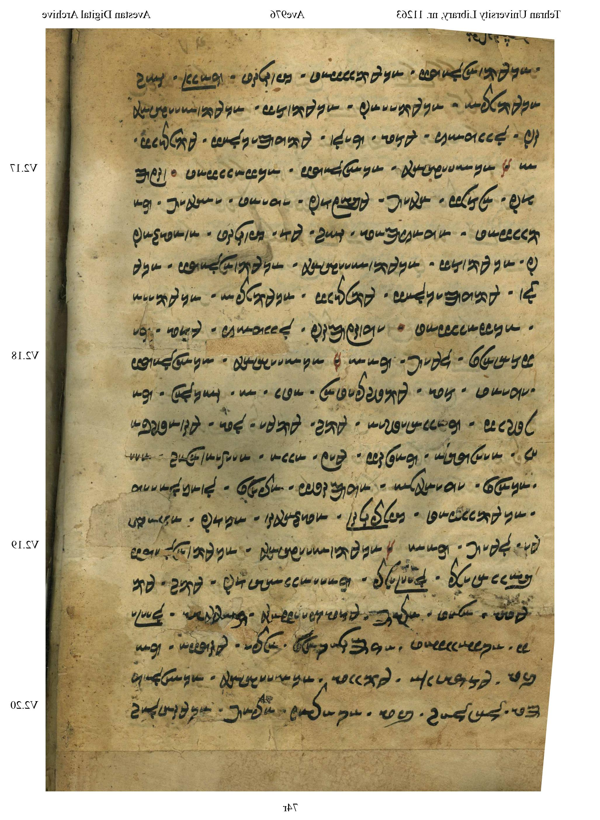

Preview: /content/mirror_work/out/Ave976_074r_mir.jpg


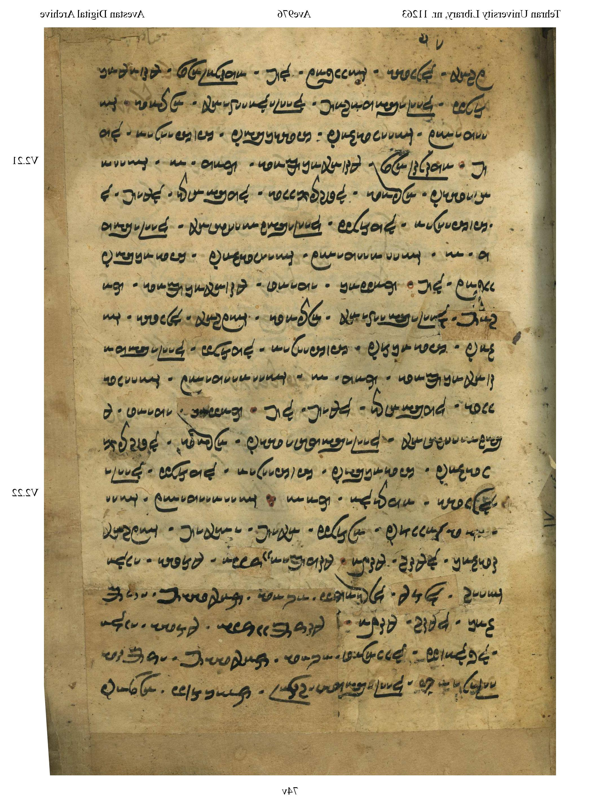

Preview: /content/mirror_work/out/Ave976_074v_mir.jpg


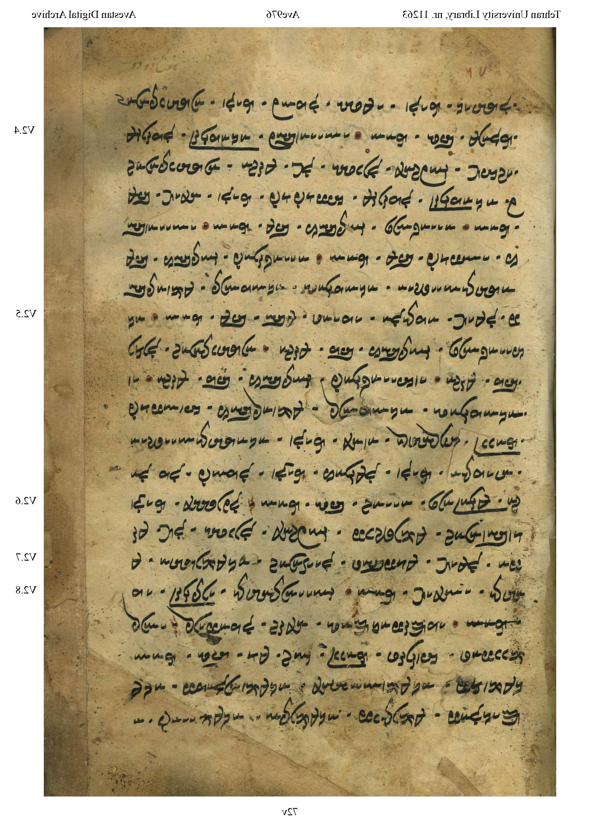

Preview: /content/mirror_work/out/Ave976_072v_mir.jpg


In [ ]:
from IPython.display import display
preview = list(itertools.islice((p for p in OUT_DIR.rglob('*') if p.is_file() and p.suffix.lower() in {'.jpg','.jpeg','.png','.tif','.tiff','.webp'}), 3))
for p in preview:
    try:
        im = Image.open(p)
        w = 600
        ratio = w / max(im.width, 1)
        im_resized = im.resize((w, max(1, int(im.height * ratio))))
        display(im_resized)
        print("Preview:", p)
    except Exception:
        print("Preview failed for:", p)

## 6) Download mirrored images

In [ ]:
from google.colab import files

zip_path = WORK / 'mirrored_images.zip'
if zip_path.exists():
    zip_path.unlink()

with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    for p in OUT_DIR.rglob('*'):
        if p.is_file():
            zf.write(p, arcname=p.relative_to(OUT_DIR))

with zipfile.ZipFile(zip_path, 'a', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(WORK/'mirror_mapping.csv', arcname='mirror_mapping.csv')

print("Ready:", zip_path)
files.download(str(zip_path))

Ready: /content/mirror_work/mirrored_images.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>